In [70]:
import os
import sys
import json
import re
import pandas as pd
from tqdm import tqdm
from soma import aims
import random

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)
    
q = os.path.abspath('../../../')
if q not in sys.path:
    sys.path.append(q)
    
from vae import *
from inference import InpaintDatasetTest
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dico_toolbox as dtx
import umap
from scipy.spatial import distance
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp

from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"

In [3]:
model_dir = '/neurospin/dico/lguillon/inpainting/v2/baseline_300/checkpoint.pt'
model = VAE((1, 80, 80, 96), 100, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

In [4]:
subject_dir = "/neurospin/dico/lguillon/distmap/data/"
data_dir = '/neurospin/dico/data/deep_folding/current/datasets/' \
                        'hcp/crops/1mm/SC/no_mask/'

test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))

filenames = np.load(os.path.join(data_dir,"Rfoldlabels", "sub_id.npy"))
distmaps = np.load(os.path.join(data_dir, 'Rskel_distmaps_junction', "Rskel_distmaps.npy"),
                   mmap_mode='r')

skeletons = np.load(os.path.join(data_dir, "Rskeletons_junction",
                                "Rskeleton.npy"),
                   mmap_mode='r')

foldlabels = np.load(os.path.join('/neurospin/dico/data/deep_folding/current/datasets/hcp/foldlabels/raw/junction/crops/',
                                    "Rlabels.npy"),
                   mmap_mode='r')
    
print(distmaps.shape, filenames.shape)

# Selection of test set only
sorter = np.argsort(filenames)
filenames_idx = sorter[np.searchsorted(filenames, np.array(test_list['subjects']), sorter=sorter)]
filenames = filenames[filenames_idx]
distmaps = distmaps[filenames_idx]
skeletons = skeletons[filenames_idx]
foldlabels = foldlabels[filenames_idx]

print(distmaps.shape)

(1114, 78, 63, 88, 1) (1114,)
(200, 78, 63, 88, 1)


In [5]:
subset = InpaintDatasetTest(foldlabels=foldlabels,
                            skeletons=skeletons,
                            distmaps=distmaps,
                            filenames=filenames,
                            data_transforms=False)
testloader = torch.utils.data.DataLoader(
               subset,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [6]:
""" SC INT """
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_arr = np.array(['111009', '138231', '510225', '199251', '159946', '140319', '212419'])

filenames_scint = np.load(os.path.join(data_dir, "Rfoldlabels", "sub_id.npy"))
distmaps_scint = np.load(os.path.join(data_dir, 'Rskel_distmaps_junction', "Rskel_distmaps.npy"),
                   mmap_mode='r')

skeletons_scint = np.load(os.path.join(data_dir, "Rskeletons_junction",
                                "Rskeleton.npy"),
                   mmap_mode='r')

foldlabels_scint = np.load(os.path.join('/neurospin/dico/data/deep_folding/current/datasets/hcp/foldlabels/raw/junction/crops/',
                                    "Rlabels.npy"),
                   mmap_mode='r')

ids = np.frompyfunc(lambda x: np.isin(x, scint_arr), 1, 1)(filenames_scint)
idxs = [i for i, curr in enumerate(ids) if curr.any()]

filenames_scint = filenames_scint[idxs]
distmaps_scint = distmaps_scint[idxs]
skeletons_scint = skeletons_scint[idxs]
foldlabels_scint = foldlabels_scint[idxs]

print(distmaps_scint.shape, filenames_scint.shape)

subset_scint = InpaintDatasetTest(foldlabels=foldlabels_scint,
                                   skeletons=skeletons_scint,
                                   distmaps=distmaps_scint,
                                   filenames=filenames_scint,
                                   data_transforms=False)
scint_loader = torch.utils.data.DataLoader(
               subset_scint,
               batch_size=1,
               num_workers=1,
               shuffle=False)

(7, 78, 63, 88, 1) (7,)


In [7]:
dico_set_loaders = {'hcp': testloader, 'scint': scint_loader}

root_dir = '/neurospin/dico/lguillon/inpainting/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = InpaintModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

results_hcp = tester_hcp.test()

print(results_hcp['scint'])
#encoded_hcp = {loader_name:[results_hcp[loader_name][k][0] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_hcp = {loader_name:[results_hcp[loader_name][k][0] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_hcp = {loader_name:[results_hcp[loader_name][k][1] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders.keys()}


print(recon_hcp)

hcp
1
932554
2
3
4
1089 638
1199 659
1244 1183
1306 675
1
387959
3
4
1202 1756
dict_keys([638, 659, 1183, 675])
('932554',)
len 4
1336 469
1
887373
3
4
1018 411
dict_keys([1756, 469])
('387959',)
len 2
1035 311
1080 1729
1302 318
1
704238
3
4
1019 395
dict_keys([411, 311, 1729, 318])
('887373',)
len 4
1114 685
1133 479
1311 390
1
169040
3
4
1066 2023
dict_keys([395, 685, 479, 390])
('704238',)
len 4
1
194746
3
4
1065 784
dict_keys([2023])
('169040',)
len 1
1171 879
1321 901
1
127832
3
4
1002 642
dict_keys([784, 879, 901])
('194746',)
len 3
1072 929
1232 501
1269 376
1
206727
3
4
1092 1671
dict_keys([642, 929, 501, 376])
('127832',)
len 4
1
679770
3
4
1033 456
dict_keys([1671])
('206727',)
len 1
1219 1007
1247 848
1
210112
3
4
1103 996
dict_keys([456, 1007, 848])
('679770',)
len 3
1134 937
1
108525
3
4
1068 1016
dict_keys([996, 937])
('210112',)
len 2
1171 612
1
742549
3
4
1080 673
dict_keys([1016, 612])
('108525',)
len 2
1099 349
1218 660
1231 1078
1
208024
3
4
1233 843
dict_keys([673,

1147 920
1280 448
1
145834
3
4
1135 944
dict_keys([940, 920, 448])
('395958',)
len 3
1374 1838
1
303624
3
4
1072 513
dict_keys([944, 1838])
('145834',)
len 2
1130 1247
1226 470
1
173334
3
4
1267 354
dict_keys([513, 1247, 470])
('303624',)
len 3
1296 1863
1
394956
3
4
1156 433
dict_keys([354, 1863])
('173334',)
len 2
1253 1535
1
141422
3
4
1122 341
dict_keys([433, 1535])
('394956',)
len 2
1217 618
1284 1794
1
638049
3
4
1144 622
dict_keys([341, 618, 1794])
('141422',)
len 3
1364 968
1
137431
3
4
1031 345
dict_keys([622, 968])
('638049',)
len 2
1109 1740
1
463040
3
4
1111 1669
dict_keys([345, 1740])
('137431',)
len 2
1123 493
1
578158
3
4
1005 516
dict_keys([1669, 493])
('463040',)
len 2
1010 1605
1
531536
3
4
1271 1074
dict_keys([516, 1605])
('578158',)
len 2
1291 924
1
173839
3
4
1123 773
dict_keys([1074, 924])
('531536',)
len 2
1222 971
1
203721
3
4
1010 301
dict_keys([773, 971])
('173839',)
len 2
1112 727
1186 1040
1
146735
3
4
1208 1008
dict_keys([301, 727, 1040])
('203721',)
len 3


1
140319
3
4
1008 1058
dict_keys([571, 638, 768, 358])
('138231',)
len 4
1041 520
1085 400
1180 328
1
199251
3
4
1081 668
dict_keys([1058, 520, 400, 328])
('140319',)
len 4
1157 929
1199 867
1
159946
3
4
1188 898
dict_keys([668, 929, 867])
('199251',)
len 3
1197 698
1252 742
1
212419
3
4
1127 1076
dict_keys([898, 698, 742])
('159946',)
len 3
1224 1030
dict_keys([1076, 1030])
('212419',)
len 2
{'111009': ([4250.099609375, 4233.052734375, 4347.17724609375], [3966.97998046875, 3956.28125, 4071.416259765625]), '510225': ([4379.376953125, 4402.80517578125], [4119.26220703125, 4138.26708984375]), '138231': ([3595.733154296875, 3508.90966796875, 3430.7177734375, 3391.97314453125], [3320.107421875, 3226.951171875, 3166.21875, 3110.947021484375]), '140319': ([2971.46142578125, 2948.893310546875, 3107.98193359375, 3242.0673828125], [2703.87646484375, 2678.10107421875, 2830.97412109375, 2970.437744140625]), '199251': ([3238.8251953125, 3285.3603515625, 3338.857421875], [2961.89599609375, 3014.451

In [8]:
results_hcp

{'hcp': {'932554': ([3497.5322265625,
    3390.792724609375,
    3402.244140625,
    3363.4345703125],
   [3220.609375, 3113.229248046875, 3123.4189453125, 3092.9111328125]),
  '387959': ([3400.585693359375, 3336.259765625],
   [3129.46435546875, 3058.234130859375]),
  '887373': ([3641.625732421875,
    3424.16162109375,
    4092.23779296875,
    3555.288330078125],
   [3356.973876953125,
    3139.015380859375,
    3815.844970703125,
    3261.24072265625]),
  '704238': ([3751.533203125, 3875.6875, 3808.65087890625, 3757.916748046875],
   [3478.25732421875, 3606.61572265625, 3532.693359375, 3480.978515625]),
  '169040': ([3348.11328125], [3075.48828125]),
  '194746': ([2960.5107421875, 2759.7294921875, 2805.152587890625],
   [2696.3349609375, 2488.726318359375, 2534.822265625]),
  '127832': ([3112.52587890625,
    3112.939453125,
    3134.75732421875,
    3268.313720703125],
   [2835.086181640625, 2824.1923828125, 2849.150390625, 2980.742919921875]),
  '206727': ([2429.552490234375], [2

In [131]:
error_max_hcp =  [max(losses_hcp['hcp'][k]) for k in range(200)]
error_max_scint =  [max(losses_hcp['scint'][k]) for k in range(7)]

recon_max_hcp =  [max(recon_hcp['hcp'][k]) for k in range(200)]
recon_max_scint =  [max(recon_hcp['scint'][k]) for k in range(7)]

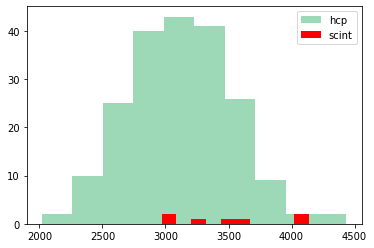

In [137]:
plt.hist(recon_max_hcp, color='mediumseagreen', alpha=0.5, label='hcp')
plt.hist(recon_max_scint, color='red', label='scint')
plt.legend()

In [133]:
F,p = mannwhitneyu(recon_max_hcp, recon_max_scint)
print(p)
F,p = ks_2samp(recon_max_hcp, recon_max_scint)
print(p)

0.015381280925196947
0.22210976606604327


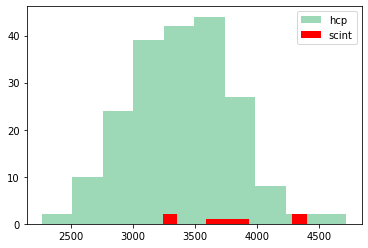

In [138]:
plt.hist(error_max_hcp, color='mediumseagreen', alpha=0.5, label='hcp')
plt.hist(error_max_scint, color='red', label='scint')
plt.legend()

In [139]:
F,p = mannwhitneyu(error_max_hcp, error_max_scint)
print(p)
F,p = ks_2samp(error_max_hcp, error_max_scint)
print(p)

0.016142166172910297
0.22210976606604327


{'whiskers': [<matplotlib.lines.Line2D at 0x7f97a0055da0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f97a0065390>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f97a0055b38>,
 'medians': [<matplotlib.lines.Line2D at 0x7f97a0065940>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f97a0065c18>,
 'means': []}

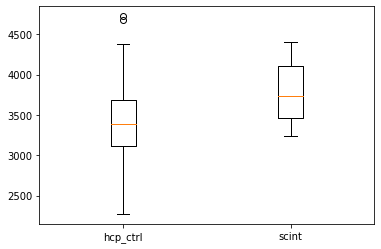

In [11]:
plt.boxplot((error_max_hcp, error_max_scint),
            labels=('hcp_ctrl','scint'))

## Loading of deletion benchmark

In [12]:
data_dir = '/neurospin/dico/lguillon/inpainting/benchmark/deletion_v2/'

In [13]:
distmaps_200 = np.load(os.path.join(data_dir, "200", "Rdistmaps.npy"),
                   mmap_mode='r')
skeletons_200 = np.load(os.path.join(data_dir, "200", "Rcrops.npy"),
                   mmap_mode='r')
foldlabels_200 = np.load(os.path.join(data_dir, "200", "Rlabels.npy"),
                   mmap_mode='r')
filenames_200 = np.load(os.path.join(data_dir, "200", "sub_id.npy"))


subset_200 = InpaintDatasetTest(foldlabels=foldlabels_200,
                        skeletons=skeletons_200,
                        distmaps=distmaps_200,
                        filenames=filenames_200,
                        data_transforms=False)
loader_200 = torch.utils.data.DataLoader(
               subset_200,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_500 = np.load(os.path.join(data_dir, "500", "Rdistmaps.npy"),
                   mmap_mode='r')
skeletons_500 = np.load(os.path.join(data_dir, "500", "Rcrops.npy"),
                   mmap_mode='r')
foldlabels_500 = np.load(os.path.join(data_dir, "500", "Rlabels.npy"),
                   mmap_mode='r')
filenames_500 = np.load(os.path.join(data_dir, "500", "sub_id.npy"))


subset_500 = InpaintDatasetTest(foldlabels=foldlabels_500,
                        skeletons=skeletons_500,
                        distmaps=distmaps_500,
                        filenames=filenames_500,
                        data_transforms=False)
loader_500 = torch.utils.data.DataLoader(
               subset_500,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_700 = np.load(os.path.join(data_dir, "700", "Rdistmaps.npy"),
                   mmap_mode='r')
skeletons_700 = np.load(os.path.join(data_dir, "700", "Rcrops.npy"),
                   mmap_mode='r')
foldlabels_700 = np.load(os.path.join(data_dir, "700", "Rlabels.npy"),
                   mmap_mode='r')
filenames_700 = np.load(os.path.join(data_dir, "700", "sub_id.npy"))


subset_700 = InpaintDatasetTest(foldlabels=foldlabels_700,
                        skeletons=skeletons_700,
                        distmaps=distmaps_700,
                        filenames=filenames_700,
                        data_transforms=False)
loader_700 = torch.utils.data.DataLoader(
               subset_700,
               batch_size=1,
               num_workers=1,
               shuffle=False)

distmaps_1000 = np.load(os.path.join(data_dir, "1000", "Rdistmaps.npy"),
                   mmap_mode='r')
skeletons_1000 = np.load(os.path.join(data_dir, "1000", "Rcrops.npy"),
                   mmap_mode='r')
foldlabels_1000 = np.load(os.path.join(data_dir, "1000", "Rlabels.npy"),
                   mmap_mode='r')
filenames_1000 = np.load(os.path.join(data_dir, "1000", "sub_id.npy"))


subset_1000 = InpaintDatasetTest(foldlabels=foldlabels_1000,
                        skeletons=skeletons_1000,
                        distmaps=distmaps_1000,
                        filenames=filenames_1000,
                        data_transforms=False)
loader_1000 = torch.utils.data.DataLoader(
               subset_1000,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [14]:
dico_set_loaders = {'200': loader_200, '500': loader_500, '700': loader_700, '1000': loader_1000}

root_dir = '/neurospin/dico/lguillon/inpainting/analyses_gridsearch/'

criterion = nn.MSELoss(reduction='sum')
tester_hcp = InpaintModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

results_deletion = tester_hcp.test()

#encoded_hcp = {loader_name:[results_hcp[loader_name][k][0] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses_deletion = {loader_name:[results_deletion[loader_name][k][0] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_deletion = {loader_name:[results_deletion[loader_name][k][1] for k in results_deletion[loader_name].keys()] for loader_name in dico_set_loaders.keys()}


print(recon_hcp)

200
1
932554
2
3
4
1001 657
1017 670
1048 640
1228 1188
1
387959
3
4
1232 1756
dict_keys([657, 670, 640, 1188])
('932554',)
len 4
1
887373
3
4
1252 318
dict_keys([1756])
('387959',)
len 1
1268 415
1289 1729
1308 311
1
704238
3
4
1002 684
dict_keys([318, 415, 1729, 311])
('887373',)
len 4
1249 396
1250 385
1391 484
1
169040
3
4
1200 2023
dict_keys([684, 396, 385, 484])
('704238',)
len 4
1
194746
3
4
1042 898
dict_keys([2023])
('169040',)
len 1
1087 882
1344 785
1
127832
3
4
1008 920
dict_keys([898, 882, 785])
('194746',)
len 3
1022 647
1027 498
1258 376
1
206727
3
4
1005 1671
dict_keys([920, 647, 498, 376])
('127832',)
len 4
1
679770
3
4
1220 846
dict_keys([1671])
('206727',)
len 1
1346 1009
1
210112
3
4
1029 996
dict_keys([846, 1009])
('679770',)
len 2
1159 935
1
108525
3
4
1069 608
dict_keys([996, 935])
('210112',)
len 2
1099 1020
1
742549
3
4
1105 660
dict_keys([608, 1020])
('108525',)
len 2
1155 351
1275 1078
1292 678
1
208024
3
4
1007 629
dict_keys([660, 351, 1078, 678])
('742549',

1262 864
1
135730
3
4
1095 1201
dict_keys([616, 864])
('733548',)
len 2
1274 337
1
104012
3
4
1011 783
dict_keys([1201, 337])
('135730',)
len 2
1039 1056
1
117122
3
4
1230 1787
dict_keys([783, 1056])
('104012',)
len 2
1272 477
1
177140
3
4
1148 1453
dict_keys([1787, 477])
('117122',)
len 2
1161 962
1
176239
3
4
1135 651
dict_keys([1453, 962])
('177140',)
len 2
1149 1307
1162 521
1
200917
3
4
1148 303
dict_keys([651, 1307, 521])
('176239',)
len 3
1265 335
1385 909
1
210011
3
4
1195 952
dict_keys([303, 335, 909])
('200917',)
len 3
1217 732
1
123824
3
4
1053 889
dict_keys([952, 732])
('210011',)
len 2
1170 708
1
275645
3
4
1290 799
dict_keys([889, 708])
('123824',)
len 2
1291 1389
1
189450
3
4
1143 1143
dict_keys([799, 1389])
('275645',)
len 2
1293 803
1
844961
3
4
1021 777
dict_keys([1143, 803])
('189450',)
len 2
1222 988
1306 679
1
167440
3
4
1043 1525
dict_keys([777, 988, 679])
('844961',)
len 3
1084 501
1178 404
1
749361
3
4
1033 314
dict_keys([1525, 501, 404])
('167440',)
len 3
1292 

1
733548
3
4
1031 864
dict_keys([991])
('146735',)
len 1
1
176239
3
4
1057 632
dict_keys([864])
('733548',)
len 1
1226 1305
1
167440
3
4
1179 413
dict_keys([632, 1305])
('176239',)
len 2
1200 1526
1
804646
3
4
1007 820
dict_keys([413, 1526])
('167440',)
len 2
1053 1235
1
211821
3
4
1069 1013
dict_keys([820, 1235])
('804646',)
len 2
1220 1085
1
453441
3
4
1123 709
dict_keys([1013, 1085])
('211821',)
len 2
1260 982
1
139839
3
4
1131 1634
dict_keys([709, 982])
('453441',)
len 2
1
126931
3
4
1007 1079
dict_keys([1634])
('139839',)
len 1
1315 680
1
611938
3
4
1066 684
dict_keys([1079, 680])
('126931',)
len 2
1222 302
1336 1109
1
268850
3
4
1046 1369
dict_keys([684, 302, 1109])
('611938',)
len 3
1
146331
3
4
1159 447
dict_keys([1369])
('268850',)
len 1
1340 1079
1
114924
3
4
1037 400
dict_keys([447, 1079])
('146331',)
len 2
1129 533
1220 517
1
547046
3
4
1112 1847
dict_keys([400, 533, 517])
('114924',)
len 3
1
905147
3
4
1247 1541
dict_keys([1847])
('547046',)
len 1
1
510326
3
4
1125 1252
di

1330 417
1
120010
3
4
1107 407
dict_keys([1089, 417])
('187850',)
len 2
1111 370
1145 416
1241 459
1
103414
3
4
1068 407
dict_keys([407, 370, 416, 459])
('120010',)
len 4
1185 935
1244 889
1
163129
3
4
1198 810
dict_keys([407, 935, 889])
('103414',)
len 3
1305 446
1
510326
3
4
1208 1253
dict_keys([810, 446])
('163129',)
len 2
1320 573
1
176037
3
4
1005 542
dict_keys([1253, 573])
('510326',)
len 2
1255 408
1261 873
1
185846
3
4
1089 1108
dict_keys([542, 408, 873])
('176037',)
len 3
1326 302
1
102311
3
4
1418 1823
dict_keys([1108, 302])
('185846',)
len 2
1
208226
3
4
1283 463
dict_keys([1823])
('102311',)
len 1
1
456346
3
4
1193 1112
dict_keys([463])
('208226',)
len 1
1215 606
1
180735
3
4
1002 1046
dict_keys([1112, 606])
('456346',)
len 2
1048 690
1
131722
3
4
1250 602
dict_keys([1046, 690])
('180735',)
len 2
1272 1022
1
406836
3
4
1128 878
dict_keys([602, 1022])
('131722',)
len 2
1
587664
3
4
1028 637
dict_keys([878])
('406836',)
len 1
1038 1100
1
412528
3
4
1116 354
dict_keys([637, 11

1
804646
3
4
1006 636
dict_keys([756])
('177342',)
len 1
1341 798
1
211821
3
4
1099 638
dict_keys([636, 798])
('804646',)
len 2
1192 1013
1
114217
3
4
1127 832
dict_keys([638, 1013])
('211821',)
len 2
1
453441
3
4
1007 707
dict_keys([832])
('114217',)
len 1
1268 491
1
978578
3
4
1
192439
3
dict_keys([707, 491])
('453441',)
len 2
dict_keys([])
('978578',)
len 0
4
1313 345
1
993675
3
4
1094 765
dict_keys([345])
('192439',)
len 1
1133 323
1
139839
3
4
1106 604
dict_keys([765, 323])
('993675',)
len 2
1
571548
3
4
1090 478
dict_keys([604])
('139839',)
len 1
1236 338
1
191235
3
4
1
126931
3
dict_keys([478, 338])
('571548',)
len 2
dict_keys([])
('191235',)
len 0
4
1047 678
1118 500
1
611938
3
4
1252 664
dict_keys([678, 500])
('126931',)
len 2
1338 491
1352 302
1
609143
3
4
1122 464
dict_keys([664, 491, 302])
('611938',)
len 3
1
187850
3
4
1167 417
dict_keys([464])
('609143',)
len 1
1264 763
1
268850
3
4
1279 661
dict_keys([417, 763])
('187850',)
len 2
1
146331
3
4
1177 637
dict_keys([661])
('

In [17]:
losses_deletion['1000']

[[3890.727783203125, 3701.683349609375, 3829.657958984375],
 [4227.875],
 [4614.603515625, 4601.60302734375, 4409.6787109375],
 [],
 [],
 [4167.17529296875, 4210.64892578125],
 [4224.576171875],
 [4029.65234375],
 [4012.969970703125, 3973.73291015625, 3860.9501953125],
 [4074.75830078125, 3693.984375],
 [4854.8720703125],
 [3898.129150390625, 3941.39208984375],
 [4053.625244140625],
 [3945.402099609375],
 [4479.197265625],
 [4193.55322265625, 4383.79638671875, 4282.0234375],
 [4184.19091796875],
 [3953.92578125, 4200.21728515625],
 [],
 [3652.40966796875],
 [4160.2451171875, 4433.1162109375],
 [4593.81787109375, 4305.5478515625],
 [4561.3408203125],
 [3992.45849609375, 4135.08642578125],
 [4541.8046875],
 [4357.349609375],
 [],
 [3499.73193359375],
 [3944.26953125, 3896.307861328125],
 [4260.52099609375],
 [3542.19677734375, 3757.150390625],
 [4035.836181640625, 4114.69970703125],
 [4143.955078125],
 [4562.0888671875],
 [4070.0654296875, 3839.24658203125, 4439.98291015625],
 [],
 [4338

In [58]:
recon_max_hcp =  [max(recon_hcp['hcp'][k]) for k in range(200)]

df_encoded_hcp = pd.DataFrame()
df_encoded_hcp['loss'] = losses_hcp['hcp']
df_encoded_hcp['recon'] = recon_max_hcp
df_encoded_hcp['Group'] = ['hcp' for k in range(len(filenames))]
df_encoded_hcp['sub'] = list(filenames)

In [19]:
error_max_200 =  [max(losses_deletion['200'][k]) for k in range(len(losses_deletion['200']))]
error_max_500 =  [max(losses_deletion['500'][k]) for k in range(len(losses_deletion['500']))]
error_max_700 =  [max(losses_deletion['700'][k]) for k in range(len(losses_deletion['700']))]
error_max_1000 =  [max(losses_deletion['1000'][k]) for k in range(len(losses_deletion['1000'])) if len(losses_deletion['1000'][k])>0 ]

In [53]:
error_max_hcp =  [max(recon_hcp['hcp'][k]) for k in range(200)]

recon_max_200 =  [max(recon_deletion['200'][k]) for k in range(len(recon_deletion['200']))]
recon_max_500 =  [max(recon_deletion['500'][k]) for k in range(len(recon_deletion['500']))]
recon_max_700 =  [max(recon_deletion['700'][k]) for k in range(len(recon_deletion['700']))]
recon_max_1000 =  [max(recon_deletion['1000'][k]) for k in range(len(recon_deletion['1000'])) if len(recon_deletion['1000'][k])>0 ]

In [78]:
results_deletion['1000']

{'932554': ([3890.727783203125, 3701.683349609375, 3829.657958984375],
  [3619.111328125, 3433.44287109375, 3564.98779296875]),
 '387959': ([4227.875], [3959.3115234375]),
 '887373': ([4614.603515625, 4601.60302734375, 4409.6787109375],
  [4340.01171875, 4323.17822265625, 4146.05615234375]),
 '169040': ([], []),
 '206727': ([], []),
 '679770': ([4167.17529296875, 4210.64892578125],
  [3894.60888671875, 3941.68994140625]),
 '210112': ([4224.576171875], [3954.6865234375]),
 '108525': ([4029.65234375], [3766.71044921875]),
 '742549': ([4012.969970703125, 3973.73291015625, 3860.9501953125],
  [3728.31005859375, 3684.640625, 3587.9951171875]),
 '193441': ([4074.75830078125, 3693.984375], [3797.99560546875, 3420.8984375]),
 '852455': ([4854.8720703125], [4597.90283203125]),
 '185442': ([3898.129150390625, 3941.39208984375],
  [3636.745361328125, 3671.550048828125]),
 '316633': ([4053.625244140625], [3800.049560546875]),
 '120414': ([3945.402099609375], [3686.24560546875]),
 '818455': ([4479.

In [86]:
deletion_200 = pd.DataFrame()
# deletion_200['latent'] = encoded_deletion['200']
deletion_200['loss'] = losses_deletion['200']  
deletion_200['recon'] = recon_max_200  
# deletion_200['input'] = input_deletion['200'] 
deletion_200['sub'] = list(filenames_200) 

deletion_500 = pd.DataFrame()
deletion_500['loss'] = losses_deletion['500']  
deletion_500['recon'] = recon_max_500 
deletion_500['sub'] = list(filenames_500) 

deletion_700 = pd.DataFrame()
deletion_700['loss'] = losses_deletion['700']  
deletion_700['recon'] = recon_max_700  
deletion_700['sub'] = list(filenames_700) 

deletion_1000 = pd.DataFrame()
deletion_1000['loss'] = error_max_1000  
deletion_1000['recon'] = recon_max_1000   
deletion_1000['sub'] = [sub for sub in results_deletion['1000'].keys() if len(results_deletion['1000'][sub][0])>0 ]

(array([ 3.,  9., 20., 23., 22., 20., 17., 10.,  8.,  1.]),
 array([3095.02197266, 3299.51015625, 3503.99833984, 3708.48652344,
        3912.97470703, 4117.46289062, 4321.95107422, 4526.43925781,
        4730.92744141, 4935.415625  , 5139.90380859]),
 <BarContainer object of 10 artists>)

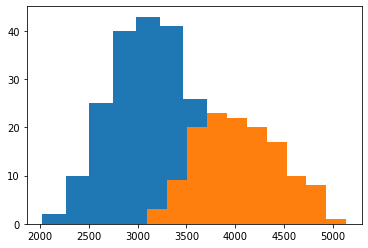

In [124]:
plt.hist(recon_max_hcp)
# plt.hist(recon_max_200)
# plt.hist(recon_max_500)
# plt.hist(recon_max_700)
plt.hist(recon_max_1000)

(array([ 3.,  9., 20., 24., 21., 19., 19.,  9.,  8.,  1.]),
 array([3355.15356445, 3561.36345215, 3767.57333984, 3973.78322754,
        4179.99311523, 4386.20300293, 4592.41289062, 4798.62277832,
        5004.83266602, 5211.04255371, 5417.25244141]),
 <BarContainer object of 10 artists>)

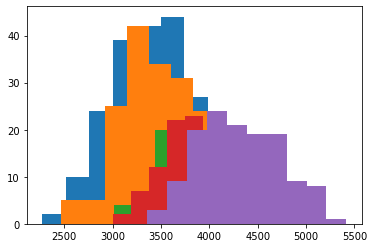

In [20]:
plt.hist(error_max_hcp)
plt.hist(error_max_200)
plt.hist(error_max_500)
plt.hist(error_max_700)
plt.hist(error_max_1000)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f967935fa20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f967936cb00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f967935fba8>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9679317860>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9679389710>,
 'means': []}

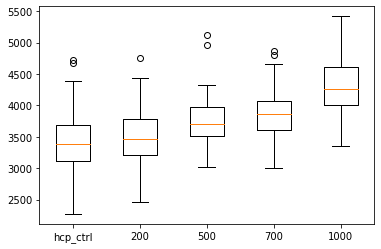

In [21]:
plt.boxplot((error_max_hcp, error_max_200, error_max_500, error_max_700, error_max_1000),
            labels=('hcp_ctrl','200', '500', '700', '1000'))

### Benchmark 200

In [59]:
list_encoded_200 = random.sample(list(deletion_200['sub']), 90)
df_encoded_200_X = deletion_200[deletion_200['sub'].astype(int).isin(list_encoded_200)]

list_ctrl = list(set(list(deletion_200['sub'].astype(int))) - set(list(df_encoded_200_X['sub'].astype(int))))
df_encoded_hcp_X_200 = df_encoded_hcp[df_encoded_hcp['sub'].astype(int).isin(list_ctrl)]

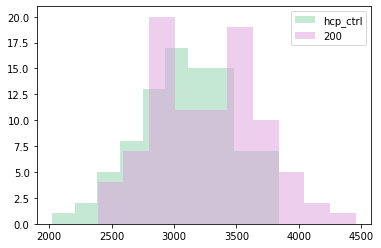

In [61]:
assert(len(df_encoded_hcp_X_200.recon)==90)
assert(len(df_encoded_200_X.recon)==90)
plt.subplot()
plt.hist(df_encoded_hcp_X_200.recon, color='mediumseagreen', alpha=0.3, label='hcp_ctrl',bins=10)
plt.hist(df_encoded_200_X.recon, color='plum', alpha=0.5, label='200', bins=10)
plt.legend()

In [71]:
F,p = mannwhitneyu(df_encoded_hcp_X_200.loss, df_encoded_200_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_200.loss, df_encoded_200_X.loss)
print(p)

0.010678118391547494
0.047134419279858654


### Benchmark 500

In [62]:
list_encoded_500 = random.sample(list(deletion_500['sub']), 34)
df_encoded_500_X = deletion_500[deletion_500['sub'].astype(int).isin(list_encoded_500)]

list_ctrl = list(set(list(deletion_500['sub'].astype(int))) - set(list(df_encoded_500_X['sub'].astype(int))))
df_encoded_hcp_X_500 = df_encoded_hcp[df_encoded_hcp['sub'].astype(int).isin(list_ctrl)]

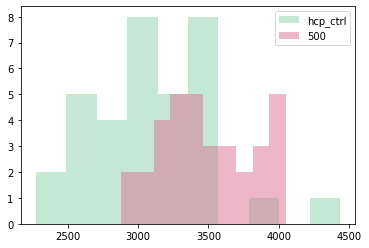

In [63]:
assert(len(df_encoded_hcp_X_500.recon)==34)
assert(len(df_encoded_500_X.recon)==34)
plt.subplot()
plt.hist(df_encoded_hcp_X_500.recon, color='mediumseagreen', alpha=0.3, label='hcp_ctrl')
plt.hist(df_encoded_500_X.recon, color='palevioletred', alpha=0.5, label='500')
plt.legend()

In [72]:
F,p = mannwhitneyu(df_encoded_hcp_X_500.loss, df_encoded_500_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_500.loss, df_encoded_500_X.loss)
print(p)

0.00027744802670491613
0.004131926146823128


### Benchmark 700

In [65]:
list_encoded_700 = random.sample(list(deletion_700['sub']), 54)
df_encoded_700_X = deletion_700[deletion_700['sub'].astype(int).isin(list_encoded_700)]

list_ctrl = list(set(list(deletion_700['sub'].astype(int))) - set(list(df_encoded_700_X['sub'].astype(int))))
df_encoded_hcp_X_700 = df_encoded_hcp[df_encoded_hcp['sub'].astype(int).isin(list_ctrl)]

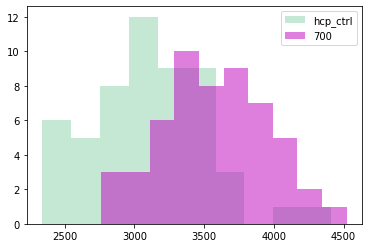

In [66]:
assert(len(df_encoded_hcp_X_700.recon)==54)
assert(len(df_encoded_700_X.recon)==54)
plt.subplot()
plt.hist(df_encoded_hcp_X_700.recon, color='mediumseagreen', alpha=0.3, label='hcp_ctrl')
plt.hist(df_encoded_700_X.recon, color='m', alpha=0.5, label='700')
plt.legend()

In [73]:
F,p = mannwhitneyu(df_encoded_hcp_X_700.loss, df_encoded_700_X.loss)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_700.loss, df_encoded_700_X.loss)
print(p)

1.669070713878525e-09
1.4614629090139238e-07


### Benchmark 1000

In [108]:
list_encoded_1000 = random.sample(list(deletion_1000['sub']), 66)
df_encoded_1000_X = deletion_1000[deletion_1000['sub'].astype(str).isin(list_encoded_1000)]

list_ctrl = list(set(list(deletion_1000['sub'].astype(str))) - set(list(df_encoded_1000_X['sub'].astype(str))))
df_encoded_hcp_X_1000 = df_encoded_hcp[df_encoded_hcp['sub'].astype(str).isin(list_ctrl)]

In [110]:
len(df_encoded_hcp_X_1000)

67

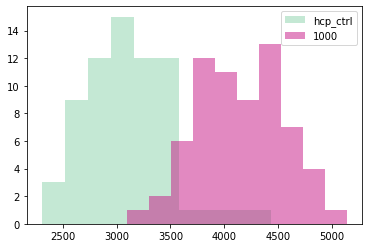

In [111]:
assert(len(df_encoded_hcp_X_1000.recon)==67)
assert(len(df_encoded_1000_X.recon)==66)
plt.subplot()
plt.hist(df_encoded_hcp_X_1000.recon, color='mediumseagreen', alpha=0.3, label='hcp_ctrl')
plt.hist(df_encoded_1000_X.recon, color='mediumvioletred', alpha=0.5, label='1000')
plt.legend()

In [115]:
F,p = mannwhitneyu(df_encoded_hcp_X_1000.recon, df_encoded_1000_X.recon)
print(p)
F,p = ks_2samp(df_encoded_hcp_X_1000.recon, df_encoded_1000_X.recon)
print(p)

1.7798461096869066e-20
4.594109785289044e-23


## Loading of Asymmetry benchmark

In [30]:
data_dir = '/neurospin/dico/lguillon/inpainting/benchmark/asymmetry_v2/flip/'

In [31]:
distmaps_asym = np.load(os.path.join(data_dir, "Ldistmaps.npy"),
                   mmap_mode='r')
skeletons_asym = np.load(os.path.join(data_dir, "Rcrops.npy"),
                   mmap_mode='r')
foldlabels_asym = np.load(os.path.join(data_dir, "Llabels.npy"),
                   mmap_mode='r')
filenames_asym = np.load(os.path.join(data_dir, "sub_id.npy"))


subset_asym = InpaintDatasetTest(foldlabels=foldlabels_asym,
                        skeletons=skeletons_asym,
                        distmaps=distmaps_asym,
                        filenames=filenames_asym,
                        data_transforms=False)
loader_asym = torch.utils.data.DataLoader(
               subset_asym,
               batch_size=1,
               num_workers=1,
               shuffle=False)

In [120]:
dico_set_loaders = {'asymmetry': loader_asym}

criterion = nn.MSELoss(reduction='sum')
tester_asym = InpaintModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=100, depth=3)

results_asym = tester_asym.test()
losses_asym = {loader_name:[results_asym[loader_name][k][0] for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
recon_asym = {loader_name:[results_asym[loader_name][k][1] for k in results_asym[loader_name].keys()] for loader_name in dico_set_loaders.keys()}


asymmetry
1
932554
2
3
4
1020 533
1130 1871
1
387959
3
4
1015 309
dict_keys([533, 1871])
('932554',)
len 2
1081 391
1229 997
1384 949
1
887373
3
4
1108 595
dict_keys([309, 391, 997, 949])
('387959',)
len 4
1140 455
1199 1005
1
704238
3
4
1019 793
dict_keys([595, 455, 1005])
('887373',)
len 3
1371 668
1
169040
3
4
1339 1654
dict_keys([793, 668])
('704238',)
len 2
1
194746
3
4
1022 1725
dict_keys([1654])
('169040',)
len 1
1239 379
1
127832
3
4
1177 814
dict_keys([1725, 379])
('194746',)
len 2
1284 793
1
206727
3
4
1082 1092
dict_keys([814, 793])
('127832',)
len 2
1247 326
1301 771
1
679770
3
4
1059 423
dict_keys([1092, 326, 771])
('206727',)
len 3
1077 804
1192 432
1294 625
1
210112
3
4
1043 413
dict_keys([423, 804, 432, 625])
('679770',)
len 4
1139 332
1192 1083
1
108525
3
4
1042 919
dict_keys([413, 332, 1083])
('210112',)
len 3
1300 685
1
742549
3
4
1133 409
dict_keys([919, 685])
('108525',)
len 2
1274 1422
1
208024
3
4
1009 676
dict_keys([409, 1422])
('742549',)
len 2
1068 302
1113 34

1240 302
1
638049
3
4
1002 962
dict_keys([1982, 302])
('141422',)
len 2
1183 742
1
137431
3
4
1016 1850
dict_keys([962, 742])
('638049',)
len 2
1
463040
3
4
1084 305
dict_keys([1850])
('137431',)
len 1
1096 591
1169 753
1
578158
3
4
1179 800
dict_keys([305, 591, 753])
('463040',)
len 3
1257 748
1277 848
1
531536
3
4
1005 1032
dict_keys([800, 748, 848])
('578158',)
len 3
1033 360
1174 876
1
173839
3
4
1128 1439
dict_keys([1032, 360, 876])
('531536',)
len 3
1
203721
3
4
1001 611
dict_keys([1439])
('173839',)
len 1
1016 791
1053 302
1097 331
1189 329
1230 351
1
146735
3
4
1019 903
dict_keys([611, 791, 302, 331, 329, 351])
('203721',)
len 6
1159 385
1245 432
1283 787
1
188145
3
4
1060 428
dict_keys([903, 385, 432, 787])
('146735',)
len 4
1092 1318
1
731140
3
4
1004 730
dict_keys([428, 1318])
('188145',)
len 2
1023 714
1
733548
3
4
1334 1043
dict_keys([730, 714])
('731140',)
len 2
1
135730
3
4
1250 1683
dict_keys([1043])
('733548',)
len 1
1
104012
3
4
1082 1034
dict_keys([1683])
('135730',)

In [122]:
error_max_asym =  [max(losses_asym['asymmetry'][k]) for k in range(len(losses_asym['asymmetry']))]
recon_max_asym =  [max(recon_asym['asymmetry'][k]) for k in range(len(recon_asym['asymmetry']))]

In [123]:
asym = pd.DataFrame()
asym['loss'] = error_max_asym 
asym['recon'] = recon_max_asym 
asym['sub'] = list(filenames_asym) 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9678b62b38>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9678b70128>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9678b628d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9678b706d8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9678b709b0>,
 'means': []}

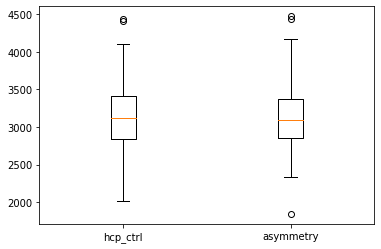

In [125]:
plt.boxplot((recon_max_hcp, recon_max_asym),
            labels=('hcp_ctrl','asymmetry'))

In [127]:
list_encoded_asym = random.sample(list(asym['sub']), 100)
df_encoded_asym_X = asym[asym['sub'].astype(int).isin(list_encoded_asym)]

list_ctrl = list(set(list(asym['sub'].astype(int))) - set(list(df_encoded_asym_X['sub'].astype(int))))
df_encoded_hcp_X_asym = df_encoded_hcp[df_encoded_hcp['sub'].astype(int).isin(list_ctrl)]

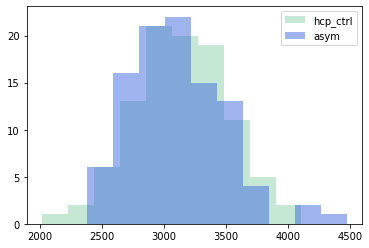

In [128]:
assert(len(df_encoded_hcp_X_asym.recon)==100)
assert(len(df_encoded_asym_X.recon)==100)
plt.subplot()
plt.hist(df_encoded_hcp_X_asym.recon, color='mediumseagreen', alpha=0.3, label='hcp_ctrl')
plt.hist(df_encoded_asym_X.recon, color='royalblue', alpha=0.5, label='asym')
plt.legend()

In [129]:
F,p = mannwhitneyu(df_encoded_asym_X.recon, df_encoded_hcp_X_asym.recon)
print(p)
F,p = ks_2samp(df_encoded_asym_X.recon, df_encoded_hcp_X_asym.recon)
print(p)

0.2321468593067204
0.556017166229757


## Reconstructions

In [160]:
with torch.no_grad():
    for distmap_masked_dict, distmap, path in testloader:
        out_z = []
        print(distmap_masked_dict.keys())
        print(path)
        for ss_size, ss in distmap_masked_dict.items():
            inputs = Variable(ss).to(device, dtype=torch.float32)
            distmap = Variable(distmap).to(device, dtype=torch.float32)
            output, z, logvar = model(inputs)
            #target = torch.squeeze(inputs, dim=1).long()
            #recon_loss_val, kl_val, loss_val = vae_loss(distmap, output, z, logvar, self.loss_func,
            #                kl_weight=self.kl_weight)
            # out_z = np.array(np.squeeze(z).cpu().detach().numpy())
            print('ici')
            #z = torch.from_numpy(z[0]).to(device, dtype=torch.float32)
            z = torch.unsqueeze(z, dim=0)
            out = model.decode(z)
            print('la')
            output = torch.argmax(out, dim=1)
            out = np.array(np.squeeze(output).cpu().detach().numpy())

1
932554
2
3


KeyboardInterrupt: 

In [ ]:
z = torch.from_numpy(z_asym[0]).to(device, dtype=torch.float32)
z = torch.unsqueeze(z, dim=0)
out = model.decode(z)
output = torch.argmax(out, dim=1)
out = np.array(np.squeeze(output).cpu().detach().numpy())

In [159]:
with torch.no_grad():
    for distmap_masked_dict, distmap, path in testloader:
        out_z = []
        print(distmap_masked_dict.keys())
        print(path)
        for ss_size, ss in distmap_masked_dict.items():
            inputs = Variable(ss).to(device, dtype=torch.float32)
            distmap = Variable(distmap).to(device, dtype=torch.float32)
            output, z, logvar = model(inputs)
            #target = torch.squeeze(inputs, dim=1).long()
            #recon_loss_val, kl_val, loss_val = vae_loss(distmap, output, z, logvar, self.loss_func,
            #                kl_weight=self.kl_weight)
            # out_z = np.array(np.squeeze(z).cpu().detach().numpy())
            print('ici')
            #z = torch.from_numpy(z[0]).to(device, dtype=torch.float32)
            z = torch.unsqueeze(z, dim=0)
            out = model.decode(z)
            print('la')
            output = torch.argmax(out, dim=1)
            out = np.array(np.squeeze(output).cpu().detach().numpy())

1
932554
2
3


KeyboardInterrupt: 

In [158]:
losses_hcp['scint']

[[4250.099609375, 4233.052734375, 4347.17724609375],
 [4379.376953125, 4402.80517578125],
 [3595.733154296875, 3508.90966796875, 3430.7177734375, 3391.97314453125],
 [2971.46142578125, 2948.893310546875, 3107.98193359375, 3242.0673828125],
 [3238.8251953125, 3285.3603515625, 3338.857421875],
 [3430.31494140625, 3566.75, 3729.126708984375],
 [3726.158447265625, 3869.1083984375]]

In [14]:
{[results_hcp[loader_name][0] for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

KeyError: 0

In [8]:
inp = np.squeeze(df_encoded_hcp['output'][150])
inp[inp>0.4] = 1
inp[inp<=0.4] = 0
aims.write(dtx.convert.volume_to_mesh(inp), '/tmp/ctrl_recon.mesh')

In [9]:
obj = np.squeeze(df_encoded_hcp['input'][150])
obj[obj>0.4] = 1
obj[obj<=0.4] = 0
aims.write(dtx.convert.volume_to_bucketMap_aims(obj), '/tmp/ctrl_in.bck')

In [10]:
inp = np.squeeze(df_encoded_hcp['output'][202])
inp[inp>0.4] = 1
inp[inp<=0.4] = 0
aims.write(dtx.convert.volume_to_mesh(inp), '/tmp/scint_recon.mesh')

In [11]:
obj = np.squeeze(df_encoded_hcp['input'][202])
obj[obj>0.4] = 1
obj[obj<=0.4] = 0
aims.write(dtx.convert.volume_to_mesh(obj), '/tmp/scint_in.mesh')

In [12]:
X_hcp = np.array(list(df_encoded_hcp['latent']))
labels_hcp = np.array(df_encoded_hcp['Group'])

from sklearn.manifold import TSNE
X_embedded_hcp = TSNE(n_components=2, random_state=12, perplexity=40).fit_transform(X_hcp)

In [13]:
scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
subjects_name_hcp = ['' for k in range(200)] + list(df_encoded_hcp[-7:]['sub'])

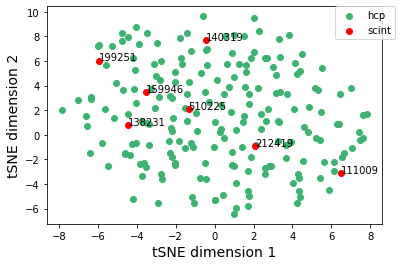

In [14]:
arr = X_embedded_hcp
color_dict = {'hcp':'mediumseagreen', 'scint': 'red'}

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

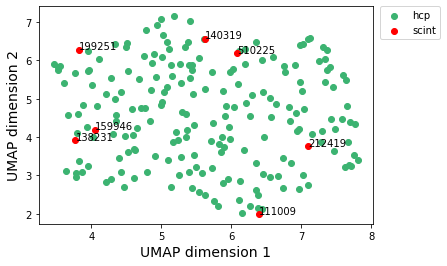

In [15]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_hcp)

fig = plt.figure()
ax = fig.subplots()

for g in np.unique(labels_hcp):
    ix = np.where(labels_hcp == g)
    x = [embedding[ix][k][0] for k in range(len(ix[0]))]
    y = [embedding[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name_hcp):
    ax.annotate(txt, (embedding[i][0], embedding[i][1]))
    
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

plt.xlabel(f'UMAP dimension 1', fontsize=14)
plt.ylabel(f'UMAP dimension 2', fontsize=14)
plt.show()

(array([1., 0., 1., 0., 0., 0., 0., 1., 3., 1.]),
 array([35287. , 35657.2, 36027.4, 36397.6, 36767.8, 37138. , 37508.2,
        37878.4, 38248.6, 38618.8, 38989. ]),
 <BarContainer object of 10 artists>)

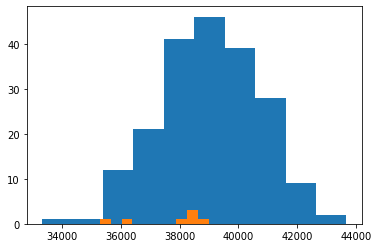

In [16]:
plt.subplot()
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss)
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='scint'].loss)

In [18]:
F,p = mannwhitneyu(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].loss, df_encoded_hcp[df_encoded_hcp.Group=='scint'].loss)
print(p)

0.021416926830885048


(array([1., 0., 1., 0., 0., 0., 0., 1., 3., 1.]),
 array([34992. , 35363.1, 35734.2, 36105.3, 36476.4, 36847.5, 37218.6,
        37589.7, 37960.8, 38331.9, 38703. ]),
 <BarContainer object of 10 artists>)

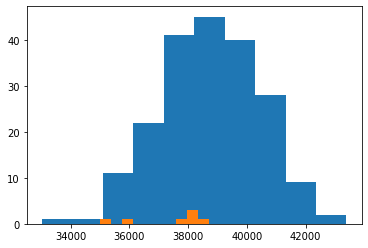

In [19]:
plt.subplot()
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].recon)
plt.hist(df_encoded_hcp[df_encoded_hcp.Group=='scint'].recon)

In [20]:
F,p = mannwhitneyu(df_encoded_hcp[df_encoded_hcp.Group=='hcp'].recon, df_encoded_hcp[df_encoded_hcp.Group=='scint'].recon)
print(p)

0.02225394264502001


In [ ]:
for sub in scint_list:  
    enc = df_encoded_hcp[df_encoded_hcp['sub']==sub].latent.values[0]
    z = torch.from_numpy(np.array(enc)).to(device, dtype=torch.float32)
    z = torch.unsqueeze(z, dim=0)
    out = model.decode(z)
    out = np.array(np.squeeze(out).cpu().detach().numpy())
    input_sub = np.copy(df_encoded_hcp[df_encoded_hcp['sub']==sub].input.values[0][0][0])
    error = input_sub - out
    error2 = out - input_sub

    out[out>0.7] = 1
    out[out<=0.7] = 0
    input_sub[input_sub>0.4] = 1
    input_sub[input_sub<=0.4] = 0
    error[error>0.4] = 1
    error[error<=0.4] = 0
    error2[error2>0.4] = 1
    error2[error2<=0.4] = 0
    
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(out), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/inpainting/analyses_gridsearch/scint_reconstructions/{sub}_out.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(input_sub), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/inpainting/analyses_gridsearch/scint_reconstructions/{sub}_in.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/inpainting/analyses_gridsearch/scint_reconstructions/{sub}_error.bck")
    aims.write(dtx.convert.bucket_numpy_to_bucketMap_aims(dtx.convert.volume_to_bucket_numpy(error2), voxel_size=(1,1,1)), f"/neurospin/dico/lguillon/inpainting/analyses_gridsearch/scint_reconstructions/{sub}_error_2.bck")

### Loss of SC int more variable ?

In [22]:
loss = []

for k in range(5):
    tester_hcp = ModelTester(model=model, dico_set_loaders=dico_set_loaders_hcp,
                         loss_func=criterion, kl_weight=2,
                         n_latent=100, depth=3)

    results_hcp = tester_hcp.test()
    losses_hcp = {loader_name:[int(results_hcp[loader_name][k][0].cpu().detach().numpy()) for k in results_hcp[loader_name].keys()] for loader_name in dico_set_loaders_hcp.keys()}
    loss.append(losses_hcp['hcp'] + losses_hcp['scint'])
    print(losses_hcp['scint'])



hcp
scint
[3689, 3669, 3145, 2572, 2757, 3175, 3182]
hcp
scint
[3736, 3690, 3100, 2615, 2974, 3179, 3230]
hcp
scint
[3831, 3704, 3178, 2558, 2789, 3215, 3141]
hcp
scint
[3762, 3696, 3019, 2591, 2895, 3183, 3094]
hcp
scint
[3714, 3746, 2994, 2546, 2893, 3123, 3202]


In [29]:
print(np.mean(loss[0][:200]))
print(np.std(loss[0][:200]))
print('scint')
print(np.mean(loss[0][200:]))
print(np.std(loss[0][200:]))
print('round 2')
print(np.mean(loss[1][:200]))
print(np.std(loss[1][:200]))
print('scint')
print(np.mean(loss[1][200:]))
print(np.std(loss[1][200:]))
print('round 3')
print(np.mean(loss[2][:200]))
print(np.std(loss[2][:200]))
print('scint')
print(np.mean(loss[2][200:]))
print(np.std(loss[2][200:]))
print('round 4')
print(np.mean(loss[3][:200]))
print(np.std(loss[3][:200]))
print('scint')
print(np.mean(loss[3][200:]))
print(np.std(loss[3][200:]))

2697.66
329.4773958862732
scint
3169.8571428571427
386.80538797083125
round 2
2694.02
329.9101538297965
scint
3217.714285714286
364.46466193023207
round 3
2689.3
340.7140002993713
scint
3202.285714285714
420.4445654935514
round 4
2688.995
330.60623856031515
scint
3177.1428571428573
390.3102899604104
